## Tutorial on getting started with graph ML
[YouTube](https://www.youtube.com/watch?v=1wcegu6ked0)


Number of nodes: 5
Number of features: 1
Number of edges: 7



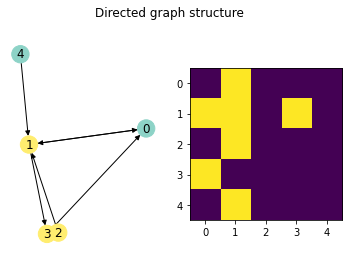

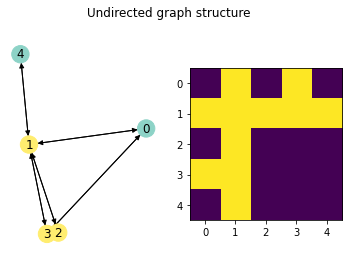

<Figure size 432x288 with 0 Axes>

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from torch_geometric.data import Data
import torch_geometric

import networkx as nx # for visualisation

# Define graph nodes and their features
x = torch.randn(5)
# Define nodes' position in 2D space
pos = torch.rand((5, 2))
# Graph edges
edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [3, 0],
                           [1, 3],
                           [2, 1],
                           [1, 1],
                           [4, 1]],
                           dtype=torch.long)

labels = [0, 1, 1, 1, 0]

# Creating the pytorch geometric object
data = Data(x=x, pos=pos, edge_index=edge_index.t().contiguous(), y=labels)

### Visualising the created graph structure ###

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Directed graph structure')

# Converting from pytorch geometric to networkx for visualization
g = torch_geometric.utils.to_networkx(data, to_undirected=False)
nx.draw(g, pos=pos.numpy(), with_labels=True, cmap=plt.get_cmap('Set3'), node_color=data.y, ax=ax1)

adj = torch_geometric.utils.to_dense_adj(data.edge_index).squeeze()
ax2.imshow(adj.numpy())

### Visualising the created graph structure as an undirected graph ###

fig2, (ax21, ax22) = plt.subplots(1, 2)
fig2.suptitle('Undirected graph structure')

undirected_edges = torch_geometric.utils.to_undirected(data.edge_index)
data_u = Data(x=x, edge_index=undirected_edges, y=labels, pos=pos)

g = torch_geometric.utils.to_networkx(data_u, to_undirected=False)
nx.draw(g, pos=pos.numpy(), with_labels=True, cmap=plt.get_cmap('Set3'), node_color=data.y, ax=ax21)

adj = torch_geometric.utils.to_dense_adj(data_u.edge_index).squeeze()
ax22.imshow(adj.numpy())

# Converting to undirected graph
plt.figure()

### Visualising the created graph structure ###
print()
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of features: {data.num_node_features}")
print(f"Number of edges: {data.num_edges}")
print()

## Building a graph classifier

In [2]:
## Download the data and print some dataset properties
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/data', name='PROTEINS')

print()
print(f"Dataset: {dataset}:")
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Extracting /tmp/data/PROTEINS/PROTEINS.zip
Processing...
Done!

Dataset: PROTEINS(1113):
Number of graphs: 1113
Number of features: 3
Number of classes: 2


In [3]:
# Construct training and test set
dataset = dataset.shuffle()

dataset_train = dataset[:1000]
dataset_test = dataset[1000:]

print(f"Number of training graphs: {len(dataset_train)}")
print(f"Number of test graphs: {len(dataset_test)}")
print()

Number of training graphs: 1000
Number of test graphs: 113




Data(edge_index=[2, 40], x=[10, 3], y=[1])
Number of nodes: 10
Number of edges: 40
Average node degree: 4.00
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True
Label: tensor([0])


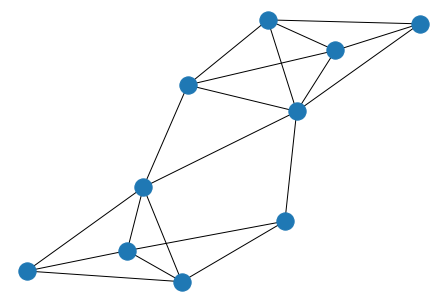

In [12]:
# Let's visualise a graph example

example = 2

data = dataset_train[example]

print()
print(data)
print('=============================================')

# Gather some statistics about the first graph.
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Average node degree: {data.num_edges / data.num_nodes:.2f}")
print(f"Contains isolated nodes: {data.contains_isolated_nodes()}")
print(f"Contains self-loops: {data.contains_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

data = dataset[example]
print("Label:", data.y)

g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g)

## Batching with pytorch geometric

Number of nodes: 1170
Number of edges: 32
Batch(batch=[1170], edge_index=[2, 4362], ptr=[33], x=[1170, 3], y=[32])


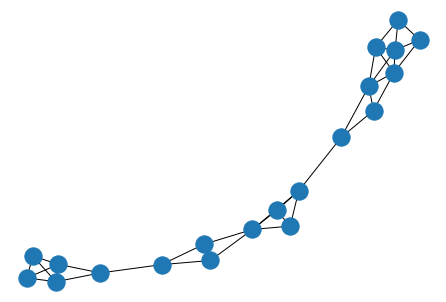

In [17]:
from torch_geometric.data import DataLoader

loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=True)

batch = next(iter(test_loader))

# Gather some statistics about the batch
print(f"Number of nodes: {batch.num_nodes}")
print(f"Number of edges: {batch.num_graphs}")
print(batch)

g = torch_geometric.utils.to_networkx(batch[0], to_undirected=True)
nx.draw(g)

## Graph convolutions
GIN convolution operator

In [20]:
from torch_geometric.utils import remove_self_loops
import torch


class GINConv(torch_geometric.nn.MessagePassing):
    def __init__(self, MLP, eps=0.0):
        super(GINConv, self).__init__(aggr='add') # Aggregation function over the message
        self.h = MLP
        self.epsilon = torch.nn.Parameter(torch.tensor([eps]))
    
    def message(self, x_j):
        return x_j
    
    def update(self, aggr_out, x):
        x = (1 + self.epsilon) * x + aggr_out
        return self.h(x)
    
    def forward(self, x, edge_index):
        edge_index, _ = remove_self_loops(edge_index)
        return self.propagate(edge_index, x=x)

In [21]:
batch = next(iter(loader))

MLP = torch.nn.Sequential(torch.nn.Linear(batch.num_node_features, 32), torch.nn.ReLU(), torch.nn.Linear(32, 32))

GIN = GINConv(MLP)
features = GIN(batch.x, batch.edge_index)
print(features)

tensor([[ 1.2316,  0.8000,  0.2487,  ..., -0.0344, -0.1046, -0.0762],
        [ 1.6460,  1.0802,  0.2946,  ..., -0.0201, -0.2331, -0.0949],
        [ 0.6232,  0.6246,  0.2935,  ...,  0.0593,  0.0274, -0.1769],
        ...,
        [ 1.1492,  0.8839,  0.3115,  ..., -0.0743, -0.0252, -0.0843],
        [ 0.8840,  0.8373, -0.1623,  ..., -0.3727,  0.6923, -0.5739],
        [ 0.8840,  0.8373, -0.1623,  ..., -0.3727,  0.6923, -0.5739]],
       grad_fn=<AddmmBackward>)


## Training a classification model on the PROTEINS dataset
We will now use our GIN convolution operator to build a trainable model for our classification task. We build a somple model with 3 convolutional layers and a global average pooling operation.<br>
Due to the batching process, average pooling across each graph is not as straightforward. Pytorch geometric has implemented so called readout layers for this purpose that can perform e.g. max and average pooling operations.

In [26]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool # readout pooling layer

torch.manual_seed(9)

class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(MLP, self).__init__()
        
        self.mlp = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden_channels),
                                      torch.nn.ReLU(),
                                      torch.nn.Linear(hidden_channels, out_channels))
        
    def forward(self, x):
        return self.mlp(x)
    
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(Net, self).__init__()
        
        self.conv1 = GINConv(MLP(in_channels, hidden_channels, hidden_channels))
        self.conv2 = GINConv(MLP(hidden_channels, hidden_channels, hidden_channels))
        self.conv3 = GINConv(MLP(hidden_channels, hidden_channels, hidden_channels))
        
        self.W = Linear(hidden_channels, num_classes)
        
    
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embedding
        x = self.conv1(x, edge_index)
        x = x.relu()
        
        x = self.conv2(x, edge_index)
        x = x.relu()
        
        x = self.conv3(x, edge_index)
        x = x.relu()
        
        x = F.dropout(x, 0.1)
        
        # 2. Global pooling layer
        x = global_mean_pool(x, batch)
        
        # 3. Classification layer
        x = self.W(x)
        
        return x

model = Net(dataset.num_node_features, 32, dataset.num_classes-1)
print(model)

Net(
  (conv1): GINConv(
    (h): MLP(
      (mlp): Sequential(
        (0): Linear(in_features=3, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      )
    )
  )
  (conv2): GINConv(
    (h): MLP(
      (mlp): Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      )
    )
  )
  (conv3): GINConv(
    (h): MLP(
      (mlp): Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      )
    )
  )
  (W): Linear(in_features=32, out_features=1, bias=True)
)


## Let's train our model

In [29]:
num_epochs = 100
device = torch.device('cpu')
# liveloss = PlotLosses()

def train():
    model.train()
    all_loss = 0
    for data in loader:
        optimizer.zero_grad()
        data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y.to(device).unsqueeze(-1).float())
        
        loss.backward()
        optimizer.step()
        
        all_loss += data.num_graphs * loss.item()
    
    return all_loss / len(loader.dataset)

def test(dataloader):
    model.eval()
    
    correct = 0
    
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            pred = torch.sigmoid(out).round().squeeze().detach().cpu().numpy()
            correct += int((pred == data.y.detach().cpu().numpy()).sum())
    return correct / len(dataloader.dataset)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss()
model = model.to(device)

for epoch in range(num_epochs):
    logs = {}
    loss = train()
    train_acc = test(loader)
    test_acc = test(test_loader)
    logs['loss'] = loss
    logs['train accuracy'] = train_acc
    logs['test accuracy'] = test_acc
#     liveloss.update(logs)
#     liveloss.send()
    print(f"Epoch: {epoch:03d}, loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch: 000, loss: 0.6801, Train Acc: 0.6420, Test Acc: 0.6637
Epoch: 001, loss: 0.6535, Train Acc: 0.7000, Test Acc: 0.6726
Epoch: 002, loss: 0.6324, Train Acc: 0.6830, Test Acc: 0.6726
Epoch: 003, loss: 0.6437, Train Acc: 0.6890, Test Acc: 0.7257
Epoch: 004, loss: 0.6280, Train Acc: 0.7020, Test Acc: 0.7168
Epoch: 005, loss: 0.6219, Train Acc: 0.7100, Test Acc: 0.7257
Epoch: 006, loss: 0.6283, Train Acc: 0.6880, Test Acc: 0.7080
Epoch: 007, loss: 0.6117, Train Acc: 0.7070, Test Acc: 0.7434
Epoch: 008, loss: 0.6033, Train Acc: 0.6860, Test Acc: 0.6814
Epoch: 009, loss: 0.6103, Train Acc: 0.7190, Test Acc: 0.7168
Epoch: 010, loss: 0.6179, Train Acc: 0.6850, Test Acc: 0.6814
Epoch: 011, loss: 0.6053, Train Acc: 0.6520, Test Acc: 0.7168
Epoch: 012, loss: 0.6178, Train Acc: 0.6880, Test Acc: 0.6637
Epoch: 013, loss: 0.6074, Train Acc: 0.7070, Test Acc: 0.7345
Epoch: 014, loss: 0.6104, Train Acc: 0.7020, Test Acc: 0.7080
Epoch: 015, loss: 0.6020, Train Acc: 0.6630, Test Acc: 0.6991
Epoch: 0